In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Binary classification of EDGE-IIOT-2022 with Decision Trees

In [3]:
data = pd.read_csv('ML-Edge_IIoT_2022-dataset.csv', low_memory=False)
data.drop('Attack_type', axis =1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157800 entries, 0 to 157799
Data columns (total 63 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   frame.time                 157800 non-null  object 
 1   ip.src_host                157800 non-null  object 
 2   ip.dst_host                157800 non-null  object 
 3   arp.dst.proto_ipv4         157800 non-null  object 
 4   arp.opcode                 157800 non-null  float64
 5   arp.hw.size                157800 non-null  float64
 6   arp.src.proto_ipv4         157800 non-null  object 
 7   icmp.checksum              157800 non-null  float64
 8   icmp.seq_le                157800 non-null  float64
 9   icmp.transmit_timestamp    157800 non-null  float64
 10  icmp.unused                157800 non-null  float64
 11  http.file_data             157800 non-null  object 
 12  http.content_length        157800 non-null  float64
 13  http.request.uri.query     15

In [4]:
counter = 0
for i in data["Attack_label"]:
    if i ==0:
        counter +=1 
print(f"Proportion of attack traffic:{counter/len(data["Attack_label"])}")

Proportion of attack traffic:0.15399873257287705


In [11]:
data.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
1,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
2,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
3,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
4,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM


<Axes: >

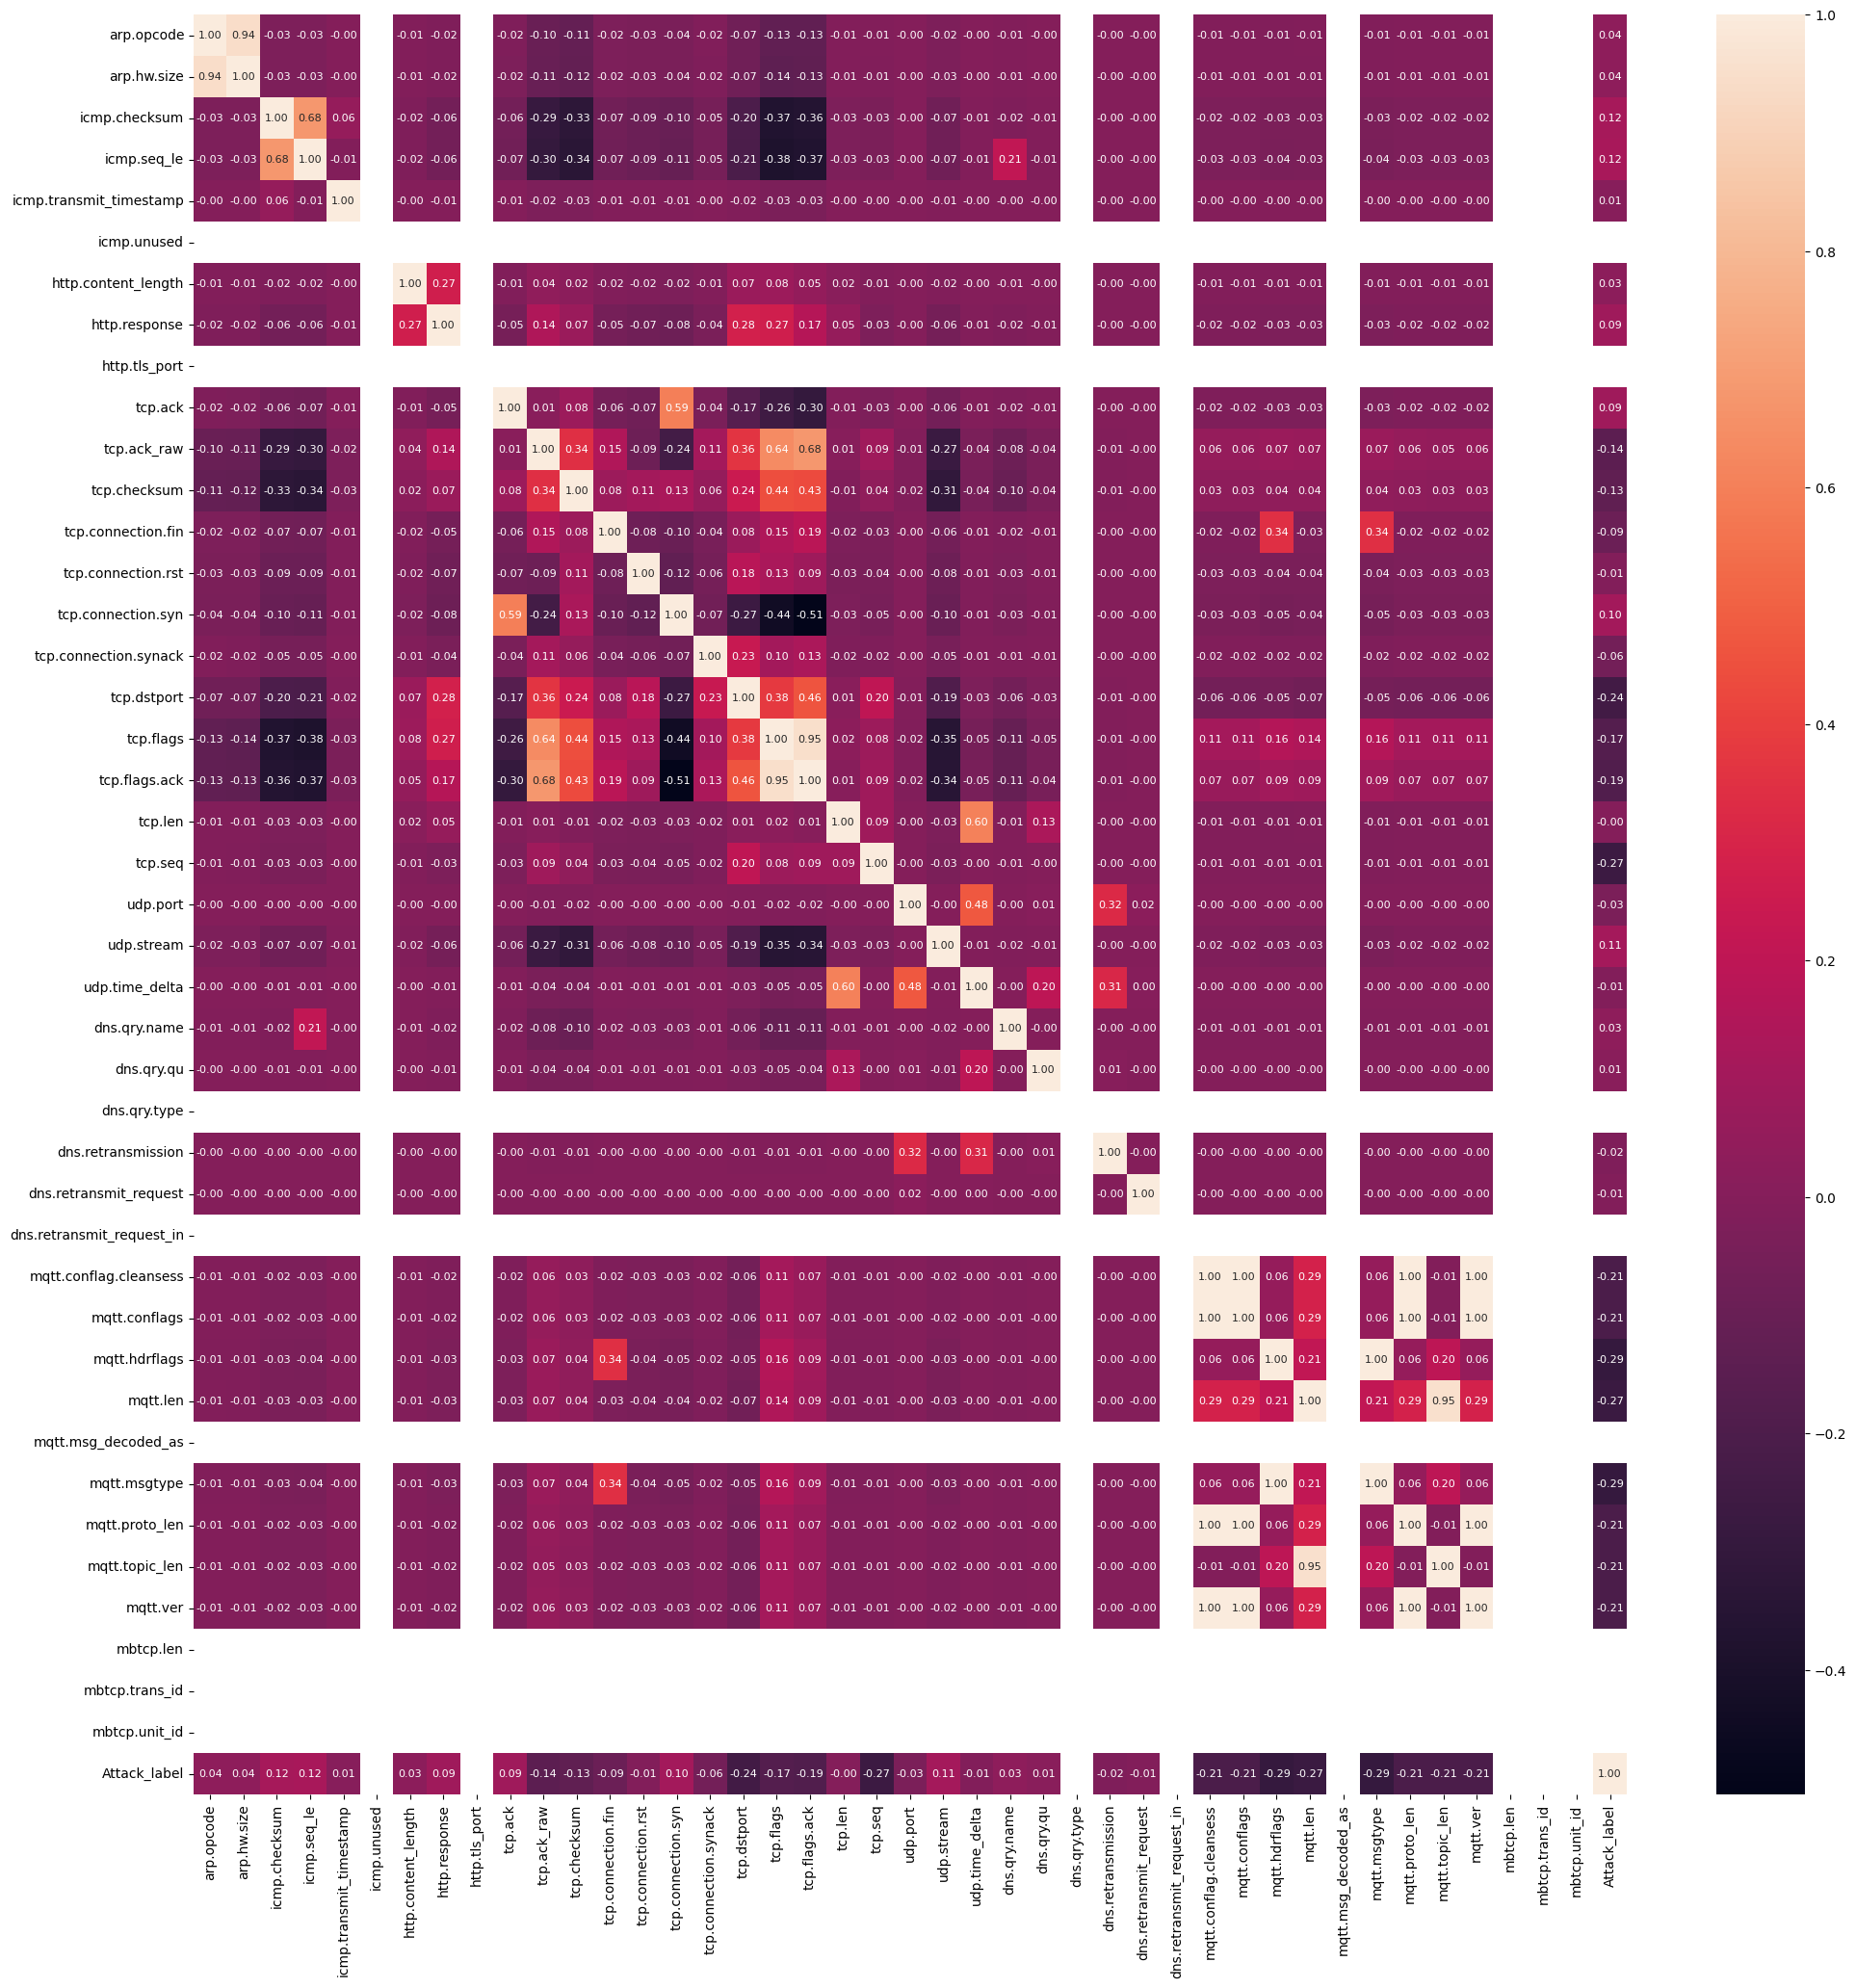

In [ ]:
#preprocess the data by removing non-numeric column entries
df_numeric = data.select_dtypes(include=['number'])

#heatmatp of the correlations of the features with binary attack variable
correlations = df_numeric.corr(method = 'pearson')
plt.figure(figsize=(24,24))
sns.heatmap(correlations, annot=True, fmt = '.2f', annot_kws={'size':8})

In [4]:
# Create a logical vector indicating whether each column is numeric
is_numeric = data.dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x))

# Drop columns that are not numeric
df_filtered = data.loc[:, is_numeric]
#or transform string entries into categorical vars when possible/ enter 

df_filtered = df_filtered.drop(['tcp.dstport', 'http.tls_port', 'udp.port'], axis = 1)
y_dec_tree = df_filtered[['Attack_label']]
DF_dec_tree = df_filtered.drop('Attack_label', axis = 1)
X_reg, y_reg = DF_dec_tree.values, y_dec_tree.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

regressor = DecisionTreeClassifier(random_state=2, max_depth = 20)
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

#recall of attacks class signficantly reduced after removal of machine-dependent variable

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      4985
           1       0.97      1.00      0.98     26575

    accuracy                           0.97     31560
   macro avg       0.97      0.93      0.95     31560
weighted avg       0.97      0.97      0.97     31560



In [5]:
attack_positions = [index for index, value in enumerate(y_pred) if value == 1]
true_attack_positions = [index for index, value in enumerate(y_test) if value == 1]
print(attack_positions[:10])
print(true_attack_positions[:10])

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 11]


In [6]:
#hyperparameter tuning of the decision tree - select best parameters of DT so as to maximise accuracy 
#by searching through a grid of possible values for the latter
from sklearn.model_selection import RandomizedSearchCV

rf = DecisionTreeClassifier(random_state=5)

param_grid = {
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_leaf': [1, 2, 3,  4, 6],
    'max_features': [1.0, 'sqrt', 'log2', None],
    'max_leaf_nodes': [2, 4, 6, 8, 10, 11, 12,  None],
}

random_search = RandomizedSearchCV(scoring="accuracy",estimator=rf, 
            param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100],
                                        'max_features': [1.0, 'sqrt', 'log2',
                                                         None],
                                        'max_leaf_nodes': [2, 4, 6, 8, 10, 11,
                                                           12, None],
                                        'min_samples_leaf': [1, 2, 3, 4, 6],
                                        'min_samples_split': [2, 4, 6, 8, 10]},
                   random_state=42, scoring='accuracy')

In [7]:
#retrieve the best estimator and use related statistics
best_dt = random_search.best_estimator_
#best_dt.fit(X_train, y_train)
#y_pred2 = best_dt.predict(X_test)
#compute accuracy and other metrics
#print(classification_report(y_test, y_pred))

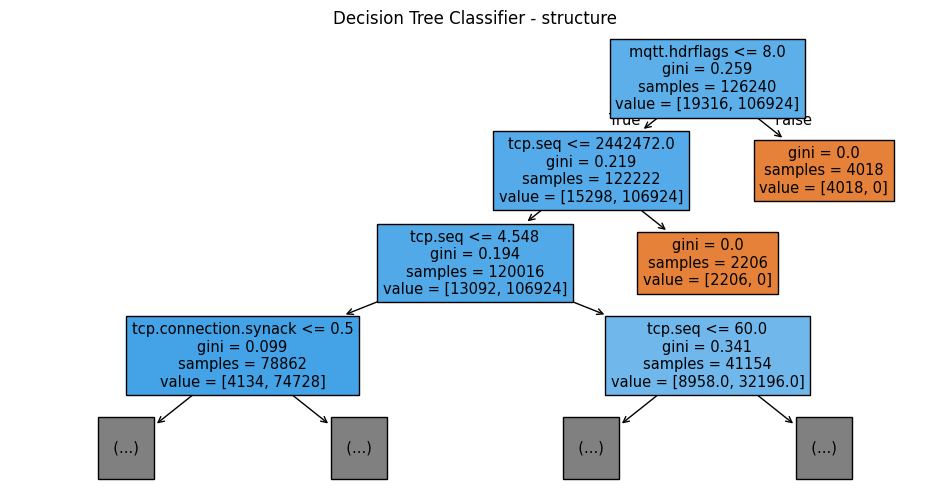

In [12]:
# Visualize the decision tree (optional)
features = [i for i in list(DF_dec_tree)]
plt.figure(figsize=(12, 6))
plot_tree(best_dt,max_depth=3, feature_names=features, filled=True )
plt.title('Decision Tree Classifier - structure')
plt.show()

In [45]:
# Perform cross-validation
from sklearn.model_selection import RepeatedKFold
RKF = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state=0)
cv_scores = cross_val_score(best_dt, X_test, y_test, cv=RKF, scoring='accuracy')

# compute the avg accuracy and std
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print(f'On average the cross-validated Accuracy is {cv_mean} with std {cv_std}')

y_pred = best_dt.predict(X_test)
print(classification_report(y_test, y_pred))

On average the cross-validated Accuracy is 0.9745817490494296 with std 0.0017579584276353009
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      4985
           1       0.97      1.00      0.99     26575

    accuracy                           0.98     31560
   macro avg       0.98      0.92      0.95     31560
weighted avg       0.98      0.98      0.97     31560



In [21]:
#extract the importance of each feature for the decision tree's predictions from best estimator
feature_importances = best_dt.feature_importances_
features = [i for i in list(DF_dec_tree)]
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)
importance_df.head(10)

,Feature,Importance
18,tcp.seq,0.595703
29,mqtt.hdrflags,0.212894
8,tcp.ack,0.140505
14,tcp.connection.synack,0.015379
17,tcp.len,0.011049
15,tcp.flags,0.009671
10,tcp.checksum,0.007806
9,tcp.ack_raw,0.004969
20,udp.time_delta,0.001654
6,http.content_length,0.000231


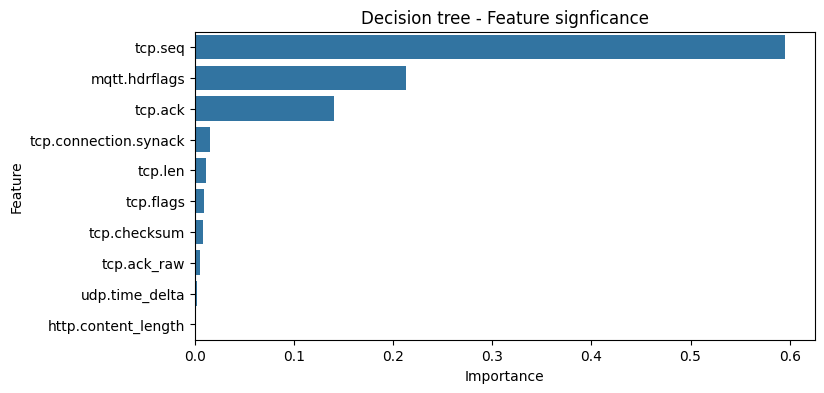

In [51]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df[:][:10])
plt.title('Decision tree - Feature signficance')
plt.tight_layout
plt.show()

## Feature selection: features whose importance according to the DT is higher than 0.001

In [46]:
imp_cols = [importance_df['Feature'][i] for i in range(len(feature_importances))  if importance_df['Importance'][i] > 0.001 ]
print(imp_cols)
df_DT_selected = df_filtered[imp_cols]
df_DT_selected.describe()

['tcp.ack', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.synack', 'tcp.flags', 'tcp.len', 'tcp.seq', 'udp.time_delta', 'mqtt.hdrflags']


,tcp.ack,tcp.ack_raw,tcp.checksum,tcp.connection.synack,tcp.flags,tcp.len,tcp.seq,udp.time_delta,mqtt.hdrflags
count,1.578000e+05,1.578000e+05,157800.000000,157800.000000,157800.000000,157800.000000,1.578000e+05,157800.000000,157800.000000
mean,7.160039e+07,1.358347e+09,25796.599163,0.029949,12.613999,129.779252,1.875111e+06,0.341407,2.581293
std,3.101231e+08,1.295523e+09,21513.031052,0.170448,9.319136,1307.037617,1.579707e+07,9.686192,20.695242
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,2982.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,1.000000e+00,1.160051e+09,23906.000000,0.000000,16.000000,0.000000,1.000000e+00,0.000000,0.000000
75%,4.790000e+02,2.372228e+09,44733.000000,0.000000,20.000000,14.000000,1.190000e+02,0.000000,0.000000
max,2.147333e+09,4.294947e+09,65535.000000,1.000000,25.000000,65228.000000,2.079647e+08,507.000000,224.000000


In [13]:
#run classification on selected features 
from sklearn.model_selection import RepeatedKFold

y_dec_tree = df_filtered[['Attack_label']]
#DF_dec_tree = df_DT_slected.drop('Attack_label', axis = 1)
X_reg, y_reg = df_DT_selected.values, y_dec_tree.values

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

regressor = DecisionTreeClassifier(random_state=2, max_depth = 20)
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      4985
           1       0.97      0.99      0.98     26575

    accuracy                           0.97     31560
   macro avg       0.97      0.92      0.95     31560
weighted avg       0.97      0.97      0.97     31560



In [14]:
rf = DecisionTreeClassifier(random_state=5)

param_grid = {
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_leaf': [1, 2, 3,  4, 6],
    'max_features': [1.0, 'sqrt', 'log2', None],
    'max_leaf_nodes': [2, 4, 6, 8, 10, 11, 12,  None],
}

random_search_sel = RandomizedSearchCV(scoring="accuracy",estimator=rf, 
            param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=42)
random_search_sel.fit(X_reg, y_reg)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100],
                                        'max_features': [1.0, 'sqrt', 'log2',
                                                         None],
                                        'max_leaf_nodes': [2, 4, 6, 8, 10, 11,
                                                           12, None],
                                        'min_samples_leaf': [1, 2, 3, 4, 6],
                                        'min_samples_split': [2, 4, 6, 8, 10]},
                   random_state=42, scoring='accuracy')

In [17]:
RKF = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state=0)
best_dt2 = random_search_sel.best_estimator_
cv_scores = cross_val_score(best_dt2, X_reg, y_reg, cv=RKF, scoring='accuracy')

# compute the avg accuracy and std
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print(f'On average the cross-validated Accuracy is {cv_mean} with std {cv_std}')

On average the cross-validated Accuracy is 0.972108998732573 with std 0.0016441485545825784


Less features lead to 1% improvement in accuracy and variance reduction

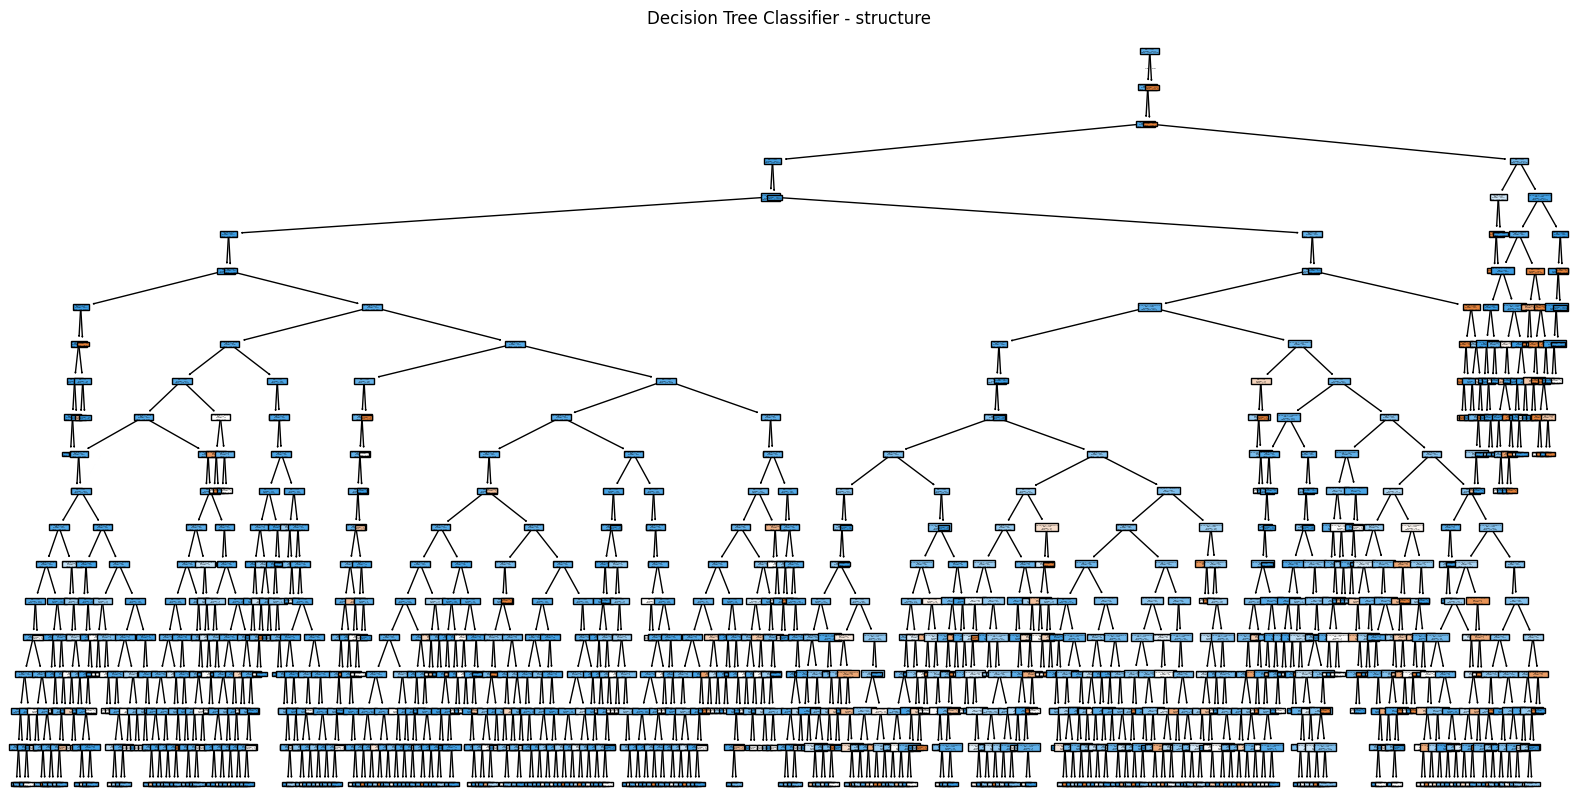

In [18]:
features = [i for i in list(df_DT_selected)]
plt.figure(figsize=(20, 10))
plot_tree(best_dt2, feature_names=features, filled=True)
plt.title('Decision Tree Classifier - structure')
plt.show()

## LASSO regression for feature selection

In [11]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

#prepare the training and test data on normalised data
y_data = df_filtered[['Attack_label']]
DF_las = df_filtered.drop('Attack_label', axis = 1)
X_las, y_las = DF_las.values, y_data.values
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_las, y_las, test_size = 0.2, random_state=5)

#standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_l)
X_test_std = scaler.transform(X_test_l)

#train lasso model
lasso = Lasso(alpha=0.01, max_iter=2000)
lasso.fit(X_train_std, y_train_l)
y_l_pred = lasso.predict(X_test_std)

results = np.round(y_l_pred) 

#print(f'Model accuracy: {counter/len(y_test_l)}')
print(classification_report(y_test_l, results))
print(f"Number of features used: {np.sum(lasso.coef_ != 0)}; Number of rejected features: {np.sum(lasso.coef_ == 0)}")
#print(f"Number of features used: {lasso.coef_}")
col_label = list(DF_las)
not_used_label = [i for i in col_label if lasso.coef_[col_label.index(i)] == 0]
used_label = [i for i in col_label if lasso.coef_[col_label.index(i)] != 0]
print(f'Unused features  = {not_used_label}\nUsed features  = {used_label}')

              precision    recall  f1-score   support

           0       1.00      0.24      0.39      4785
           1       0.88      1.00      0.94     26775

    accuracy                           0.88     31560
   macro avg       0.94      0.62      0.66     31560
weighted avg       0.90      0.88      0.85     31560

Number of features used: 16; Number of rejected features: 26
Unused features  = ['arp.opcode', 'arp.hw.size', 'icmp.transmit_timestamp', 'icmp.unused', 'http.content_length', 'http.tls_port', 'tcp.ack_raw', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'udp.time_delta', 'dns.qry.name', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request', 'dns.retransmit_request_in', 'mqtt.msg_decoded_as', 'mqtt.topic_len', 'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id']
Used features  = ['icmp.checksum', 'icmp.seq_le', 'http.response', 'tcp.ack', 'tcp.checksum', 'tcp.dstpo

In [21]:
feature_names = [f'{DF_las.columns[i]}' for i in range(X_las.shape[1])]

# Get coefficients
coefficients = lasso.coef_

# Combine coefficients and feature names into a DataFrame
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
coef_df.head(10)

,Feature,Coefficient
7,http.response,0.041016
22,udp.stream,0.008151
3,icmp.seq_le,0.006681
9,tcp.ack,0.006111
2,icmp.checksum,0.004452
28,dns.retransmit_request,-0.000000
23,udp.time_delta,-0.000000
24,dns.qry.name,0.000000
25,dns.qry.qu,0.000000
26,dns.qry.type,0.000000


In [7]:
from sklearn.model_selection import RandomizedSearchCV

ls = Lasso(max_iter=1500)

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 50, 100],
}

random_search_sel = RandomizedSearchCV(scoring="neg_mean_squared_error",estimator=ls, 
            param_distributions=param_grid, cv=5, n_jobs=2, random_state=42)
random_search_sel.fit(X_las, y_las)

RandomizedSearchCV(cv=5, estimator=Lasso(max_iter=1500), n_jobs=2,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  2, 5, 10, 50, 100]},
                   random_state=42, scoring='neg_mean_squared_error')

In [13]:
#to try
from sklearn.model_selection import RepeatedKFold

best_ls = random_search_sel.best_estimator_
RKF = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state=0)

cv_scores = cross_val_score(best_ls, X_reg, y_reg, cv=RKF, scoring='neg_mean_squared_error')

# compute the avg accuracy and std
cv_mean = np.mean(-cv_scores)
cv_std = np.std(cv_scores)
print(f'On average the cross-validated mean_squared error is {cv_mean} with std {cv_std}')

On average the cross-validated mean_squared error is 0.11355330432960979 with std 0.0008695516651729807


In [ ]:
# not really successful
y_l_pred = best_ls.predict(X_test_l)

results = np.round(y_l_pred) 

#print(f'Model accuracy: {counter/len(y_test_l)}')
print(classification_report(y_test_l, results))

              precision    recall  f1-score   support

           0       1.00      0.09      0.16      4785
           1       0.86      1.00      0.92     26775

    accuracy                           0.86     31560
   macro avg       0.93      0.54      0.54     31560
weighted avg       0.88      0.86      0.81     31560

